In [385]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import genextreme , norm

#for MCMC
import pymc as pm
import pymc_extras.distributions as pmx
import arviz as az
from arviz.plots import plot_utils as azpu

#for plotting
from matplotlib.collections import LineCollection
import seaborn as sns

### Data

Data is annual maximum sea level (m) measured in Port Pirie in Australia. Source of this data is from Coles (2001).

In [386]:
portpirie = pd.read_csv("data/portpirie.csv",sep=";")
portpirie.head(5)

,Year,SeaLevel
0,1923,4.03
1,1924,3.83
2,1925,3.65
3,1926,3.88
4,1927,4.01


In [387]:
np.array(portpirie.SeaLevel)

array([4.03, 3.83, 3.65, 3.88, 4.01, 4.08, 4.18, 3.8 , 4.36, 3.96, 3.98,
       4.69, 3.85, 3.96, 3.85, 3.93, 3.75, 3.63, 3.57, 4.25, 3.97, 4.05,
       4.24, 4.22, 3.73, 4.37, 4.06, 3.71, 3.96, 4.06, 4.55, 3.79, 3.89,
       4.11, 3.85, 3.86, 3.86, 4.21, 4.01, 4.11, 4.24, 3.96, 4.21, 3.74,
       3.85, 3.88, 3.66, 4.11, 3.71, 4.18, 3.9 , 3.78, 3.91, 3.72, 4.  ,
       3.66, 3.62, 4.33, 4.55, 3.75, 4.08, 3.9 , 3.88, 3.94, 4.33])

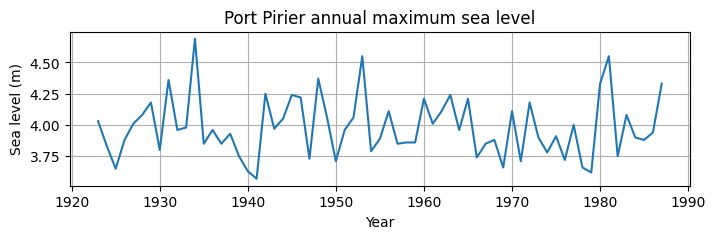

In [388]:
plt.figure(figsize=(8, 2))  
plt.plot(portpirie.Year,portpirie.SeaLevel)
plt.xlabel('Year')
plt.ylabel('Sea level (m)')
plt.title('Port Pirier annual maximum sea level')
plt.grid(True) 
plt.show()

There are different approaches to estimate the empirical return levels and return periods, below a comparison of the three methodos (Gringorten, Weibull and Cunnane)

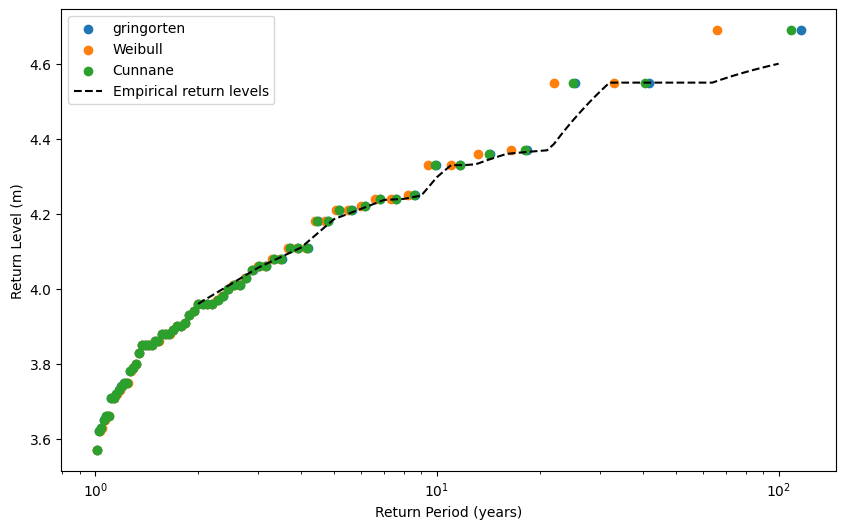

In [427]:
def gringorten(i, n):
    return (i - 0.44) / (n + 0.12)

def Weibull(i, n):
    return i/(n+1) 

def Cunnane(i,n):
    return (i - 0.4)/(n + 0.2)

#Empirical return periods
return_periods = np.array(list(range(2,101)))
return_levels_obs = np.quantile(portpirie.SeaLevel,1-1/return_periods)

sorted_data = np.sort(portpirie.SeaLevel)
n = len(sorted_data)

pp_gringorten = np.array([gringorten(i+1, n) for i in range(n)])
pp_Weibull = np.array([Weibull(i+1, n) for i in range(n)])
pp_Cunnane = np.array([Cunnane(i+1, n) for i in range(n)])

gringorten_return_periods = 1 / (1 - pp_gringorten)
Weibull_return_periods = 1 / (1 - pp_Weibull)
Cunnane_return_periods = 1 / (1 - pp_Cunnane)

plt.figure(figsize=(10, 6))
plt.scatter(gringorten_return_periods, sorted_data, marker='o', label='gringorten')
plt.scatter(Weibull_return_periods, sorted_data, marker='o', label='Weibull')
plt.scatter(Cunnane_return_periods, sorted_data, marker='o', label='Cunnane')
plt.plot(return_periods, return_levels_obs,color='black', label='Empirical return levels',linestyle='dashed')
plt.xscale('log')  
plt.xlabel('Return Period (years)')
plt.ylabel('Return Level (m)')
plt.legend()
plt.show()


### Frequentist approach

My writting is so bad, I can't even think in a proper title for this section. First, I'll fit a Generalized Extreme Value (GEV) model to the Port Pirie data. It seems appropriate because the data is already grouped in annual blocks, the distance between consecutive observations is large enough to assume they are independent from each other.

$$
G(z) = 1 
- exp 
\left\{
\left[
    - 1+\xi 
    \left(
        \frac{z-\mu}{\sigma}
    \right) 
\right]^{-1/\xi}
\right\}
$$

Where $z_p$ is the return level with probability p of occuring at any year. $y_p$ = -log(1 - p)
$$
z_p = \mu - \frac{-\sigma}{\xi} [1 - y_p^{-\xi}]
$$

And the return period (r)
$$
p = 1 - \frac{1}{r}
$$
For the 100 year return period (r = 100), p = 0.99

If $\xi$ < 0, the upper bound limit $z_0$ is
$$
z_0 = \mu - \frac{\sigma}{\xi}
$$

Uncertainty of $z_p$ by the delta method:

$$
Var(z_p) = \nabla z_p^T V \nabla z_p
$$

Where V is the variance-covariance matrix of ($\mu$,$\sigma$,$\xi$). And:

$$
\nabla z_p^T = \left[\frac{\partial z_p}{\partial \mu},\frac{\partial z_p}{\partial \sigma},\frac{\partial z_p}{\partial \xi}\right]
$$

Given the formulation of $z_p$, is convenient to plot $z_p$ x -log(1-p)

Estimate parameters by MLE:

In [495]:
#Fit GEV using the scipy genextreme function
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.genextreme.html
gev_params = genextreme.fit(portpirie.SeaLevel)
print(np.round(gev_params,4))

xi = -gev_params[0]
mu = gev_params[1]
sigma = gev_params[2]

[0.0501 3.8748 0.198 ]


`scipy.genextreme` returns the GEV fitted parameters in the order ($-\xi$,$\mu$,$\sigma$)

| $\mu$  |  $\sigma$ | $\xi$  |
|---|---|---|
| 3.8748  | 0.198  | -0.0501  |

ps: table generated by [https://www.tablesgenerator.com/markdown_tables](https://www.tablesgenerator.com/markdown_tables)

In [411]:
#Assign fitted model to variable `gev_fit` and calculate the four first moments (mean, variance, skewness, kurtois)
gev_fit = genextreme(*gev_params)
print(np.round(gev_fit.stats(moments='mvsk'),4))

[3.9797 0.0571 0.8674 1.2654]


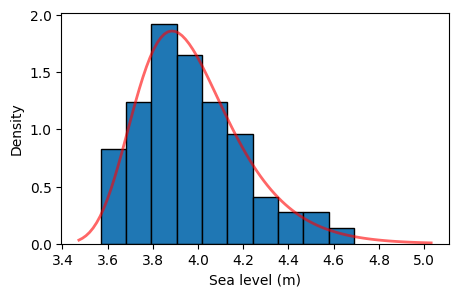

In [412]:
x = np.linspace(gev_fit.ppf(0.001),gev_fit.ppf(0.999), 100)

plt.figure(figsize=(5,3))
plt.hist(portpirie.SeaLevel,density=True,edgecolor='black')
plt.plot(x, gev_fit.pdf(x),'r-', lw=2, alpha=0.6, label='genextreme pdf')
plt.xlabel("Sea level (m)")
plt.ylabel("Density")
plt.show()

Looking into the return levels

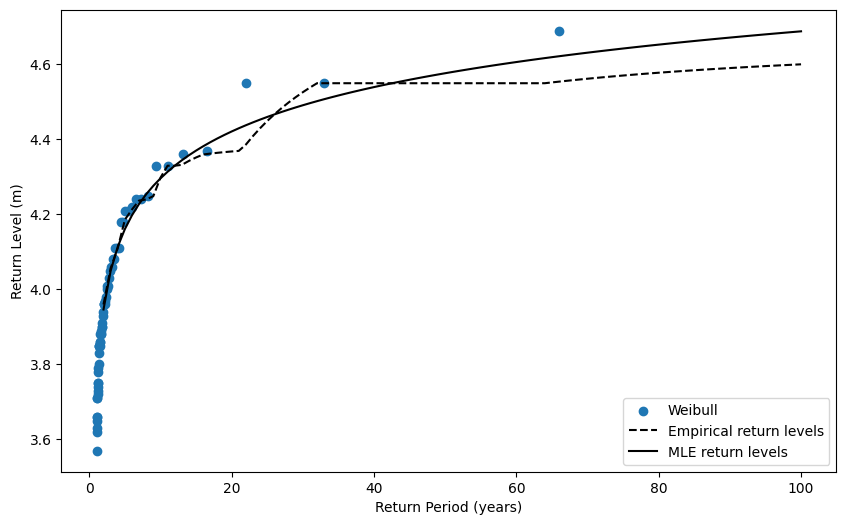

In [429]:
mle_return_levels = gev_fit.ppf(1-1/return_periods)

plt.figure(figsize=(10, 6))
#plt.scatter(gringorten_return_periods, sorted_data, marker='o', label='gringorten',s=15)
plt.scatter(Weibull_return_periods, sorted_data, marker='o', label='Weibull')
#plt.scatter(Cunnane_return_periods, sorted_data, marker='o', label='Cunnane',s=5)
plt.plot(return_periods, return_levels_obs,color='black', label='Empirical return levels',linestyle='dashed')
plt.plot(return_periods, mle_return_levels,color='black', label='MLE return levels')
#plt.xscale('log')  
plt.xlabel('Return Period (years)')
plt.ylabel('Return Level (m)')
plt.legend()
plt.show()

To calculate the variance-covariance matrix, Colles (2001) approximate the distribution of ($\mu$,$\sigma$,$\xi$) as multivariate normal and the variance-covariance matrix equal to the inverse of the observed Fisher information matrix evaluated at the maximum likelihood estimate. This demands some effort to implement, here I'll be skipping this part and going straight to bootstrap.

In [417]:
#Using parametric bootstrap for parameter error estimation
n_bootstrap = 1000
N = portpirie.shape[0]
bootstrap_params = np.zeros((n_bootstrap, 3))
return_levels_boot = np.zeros((n_bootstrap,len(return_periods)))

for i in range(n_bootstrap):
    synthetic_data = gev_fit.rvs(size=N)
    result = genextreme.fit(synthetic_data)
    # Use the fitted parameters to calculate return levels
    xi_boot = -result[0] 
    mu_boot = result[1]
    sigma_boot = result[2]
    
    # Calculate theoretical return levels
    boot_fit = genextreme(-xi_boot, loc=mu_boot, scale=sigma_boot)
    return_levels_boot[i,:] = boot_fit.ppf(1-1/return_periods)
    bootstrap_params[i] = np.array([mu_boot, sigma_boot, xi_boot])

In [ ]:
boot_mean = np.mean(return_levels_boot, axis=0)
boot_std = np.std(return_levels_boot, axis=0)
upper = boot_mean + 1.96 * boot_std
lower = boot_mean - 1.96 * boot_std

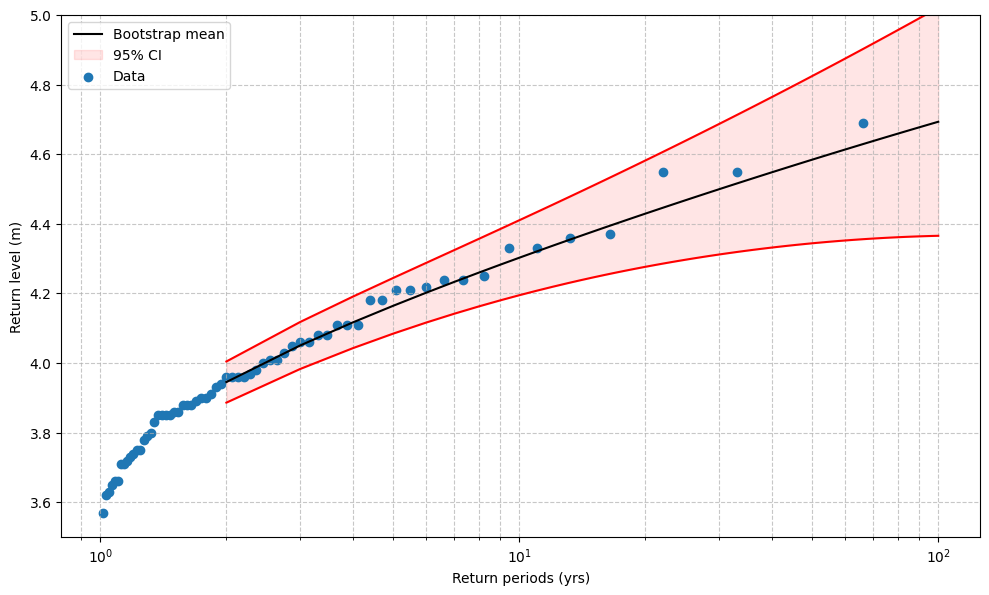

In [472]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(return_periods,2*mle_return_levels - lower,color='red')
ax.plot(return_periods,2*mle_return_levels-boot_mean,color='black',label='Bootstrap mean')
ax.plot(return_periods,2 * mle_return_levels-upper,color='red')
ax.fill_between(return_periods, 2*mle_return_levels - upper, 2*mle_return_levels - lower, alpha=0.1, color='red', label='95% CI')
ax.scatter(Weibull_return_periods, sorted_data, marker='o', label='Data')
ax.autoscale()
ax.set_xlabel('Return periods (yrs)')
ax.set_ylabel('Return level (m)')
ax.set_xscale('log')
plt.tight_layout()
plt.ylim(3.5,5)
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend(loc='upper left');

In [439]:
print("bootstrap estimates")
print("mu mean: ",
np.mean(bootstrap_params.reshape(n_bootstrap,3)[:,0]),
"standard deviation: ",
np.std(bootstrap_params.reshape(n_bootstrap,3)[:,0]))

print("sigma mean: ",
np.mean(bootstrap_params.reshape(n_bootstrap,3)[:,1]),
"standard deviation: ",
np.std(bootstrap_params.reshape(n_bootstrap,3)[:,1]))

print("xi mean: ",
np.mean(bootstrap_params.reshape(n_bootstrap,3)[:,2]),
"standard deviation: ",
np.std(bootstrap_params.reshape(n_bootstrap,3)[:,2]))

bootstrap estimates
mu mean:  3.8768633228990668 standard deviation:  0.027362224305526563
sigma mean:  0.19611944461696856 standard deviation:  0.019315644477348074
xi mean:  -0.056778843251855206 standard deviation:  0.0974012850333207


### Bayesian model

check prior probabilistic inversion to include knowledge

In [442]:
# Optionally centre the data, depending on fitting and divergences
# cdata = (data - data.mean())/data.std()

#p = 1/10
y = np.array(portpirie.SeaLevel)

with pm.Model() as model:
    # Priors
#    μ = pm.Normal("μ", mu=0, sigma=10000)
#    σ = pm.Normal("σ", mu=0, sigma=10000)
#    ξ = pm.Normal("ξ", mu=0, sigma=100)

    μ = pm.Normal("μ", mu=3.8, sigma=0.2)
    σ = pm.HalfNormal("σ", sigma=0.3)
    ξ = pm.TruncatedNormal("ξ", mu=0, sigma=0.2, lower=-0.6, upper=0.6)

    # Estimation
    gev = pmx.GenExtreme("gev", mu=μ, sigma=σ, xi=ξ, observed=y)
    # Return level
    #z_p = pm.Deterministic("z_p", μ - σ / ξ * (1 - (-np.log(1 - p)) ** (-ξ)))

In [443]:
idata = pm.sample_prior_predictive(samples=1000, model=model)

Sampling: [gev, μ, ξ, σ]


Prior predictive check

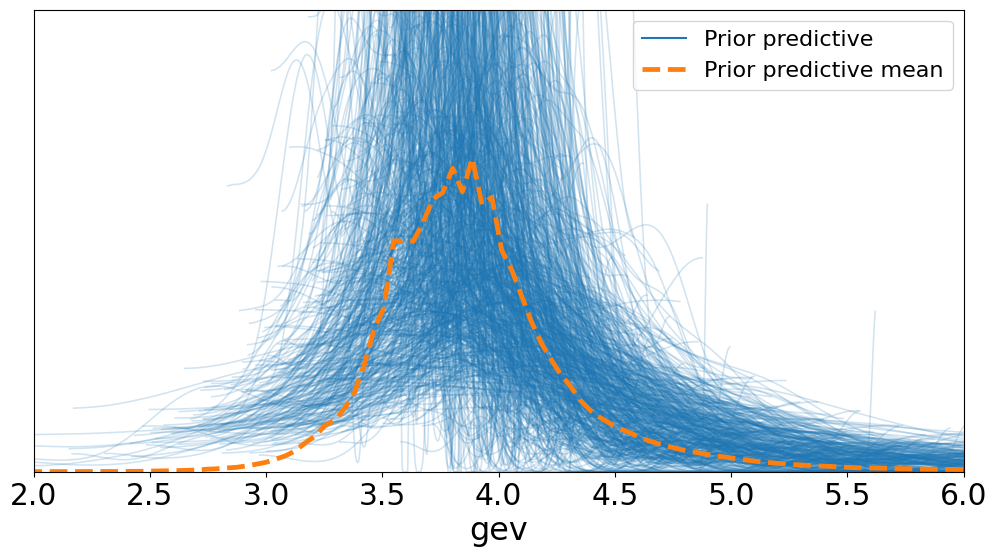

In [444]:
az.plot_ppc(idata, group="prior", figsize=(12, 6))
ax = plt.gca()
ax.set_xlim([2, 6])
ax.set_ylim([0, 2]);

Prior distributions

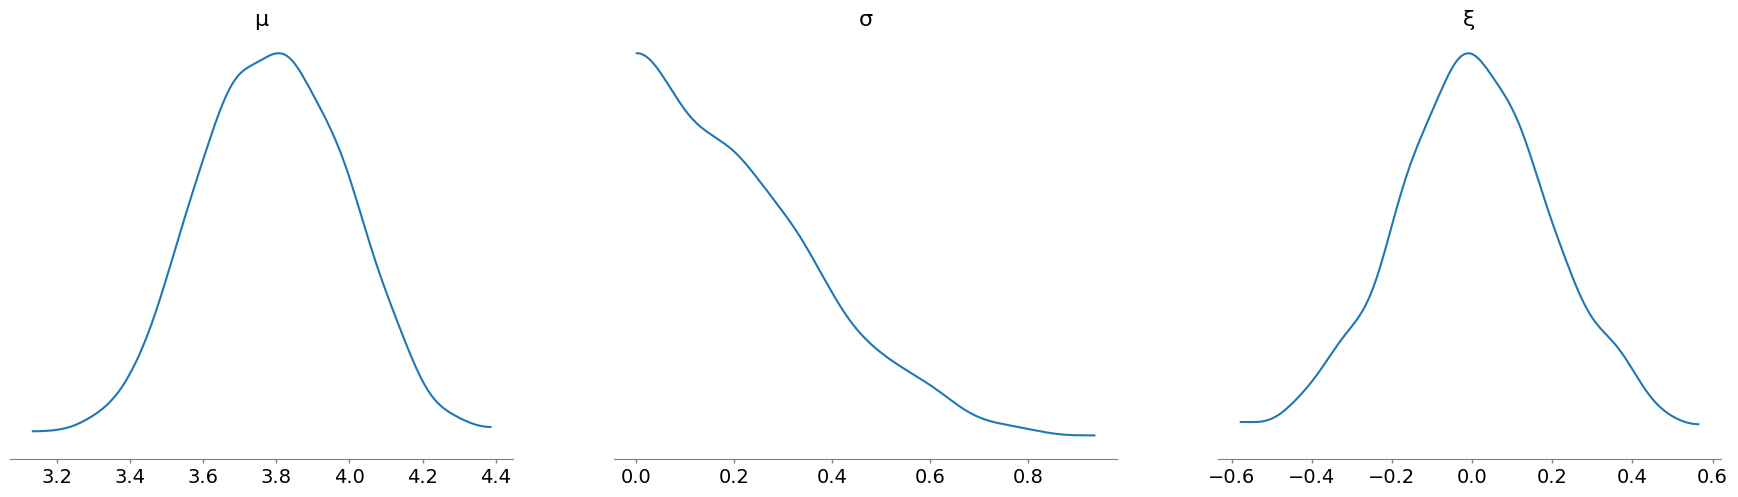

In [445]:
az.plot_posterior(
    idata, group="prior", var_names=["μ", "σ", "ξ"], hdi_prob="hide", point_estimate=None
);

In [447]:
with model:
    trace = pm.sample(
        5000,
        cores=4,
        chains=4,
        tune=2000,
        initvals={"μ": -0.5, "σ": 1.0, "ξ": -0.1},
        target_accept=0.98,
        progressbar = True
    )
# add trace to existing idata object
idata.extend(trace)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [μ, σ, ξ]


Output()

Sampling 4 chains for 2_000 tune and 5_000 draw iterations (8_000 + 20_000 draws total) took 4 seconds.
There were 16 divergences after tuning. Increase `target_accept` or reparameterize.


Check chains convergence

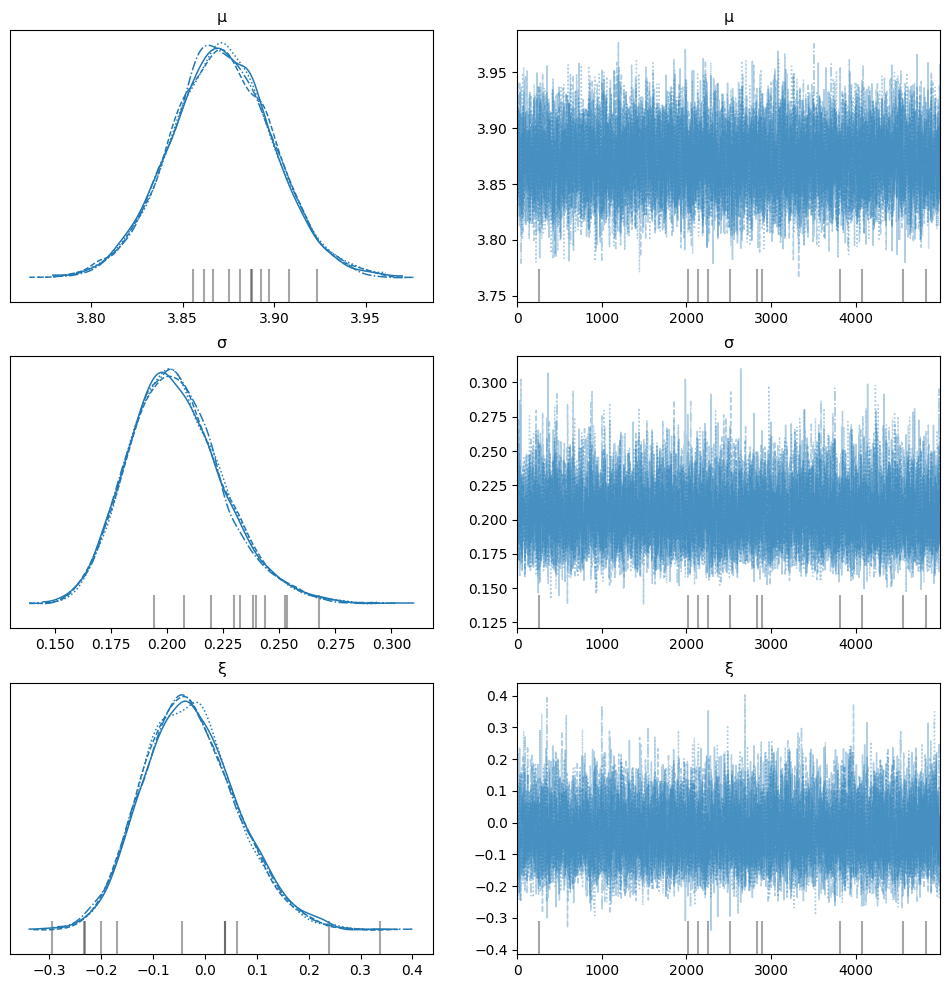

In [448]:
az.plot_trace(idata, var_names=["μ", "σ", "ξ"], figsize=(12, 12));

In [449]:
az.hdi(idata, hdi_prob=0.95)

<xarray.Dataset> Size: 96B
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 48B 'lower' 'higher'
Data variables:
    μ        (hdi) float64 16B 3.814 3.925
    σ        (hdi) float64 16B 0.164 0.2464
    ξ        (hdi) float64 16B -0.1956 0.154

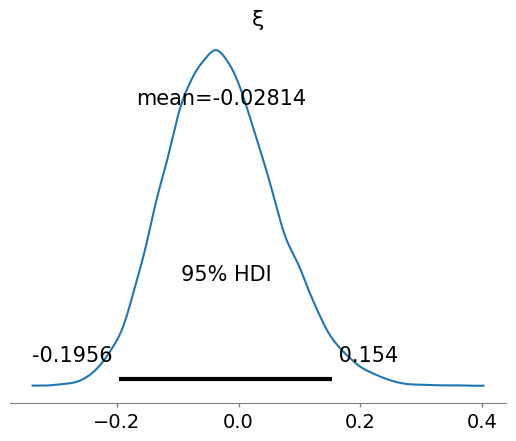

In [450]:
az.plot_posterior(idata, hdi_prob=0.95, var_names=["ξ"], round_to=4);

In [474]:
_, vals = az.sel_utils.xarray_to_ndarray(idata["posterior"], var_names=["μ", "σ", "ξ"])
mle = [azpu.calculate_point_estimate("mode", val) for val in vals]
mle


[np.float64(3.8705716497590643),
 np.float64(0.20023212354755895),
 np.float64(-0.036859198013969224)]

In [475]:
idata["posterior"].to_dataframe().cov().round(6)

,μ,σ,ξ
μ,0.000786,0.000184,-0.000795
σ,0.000184,0.000449,-0.000593
ξ,-0.000795,-0.000593,0.008111


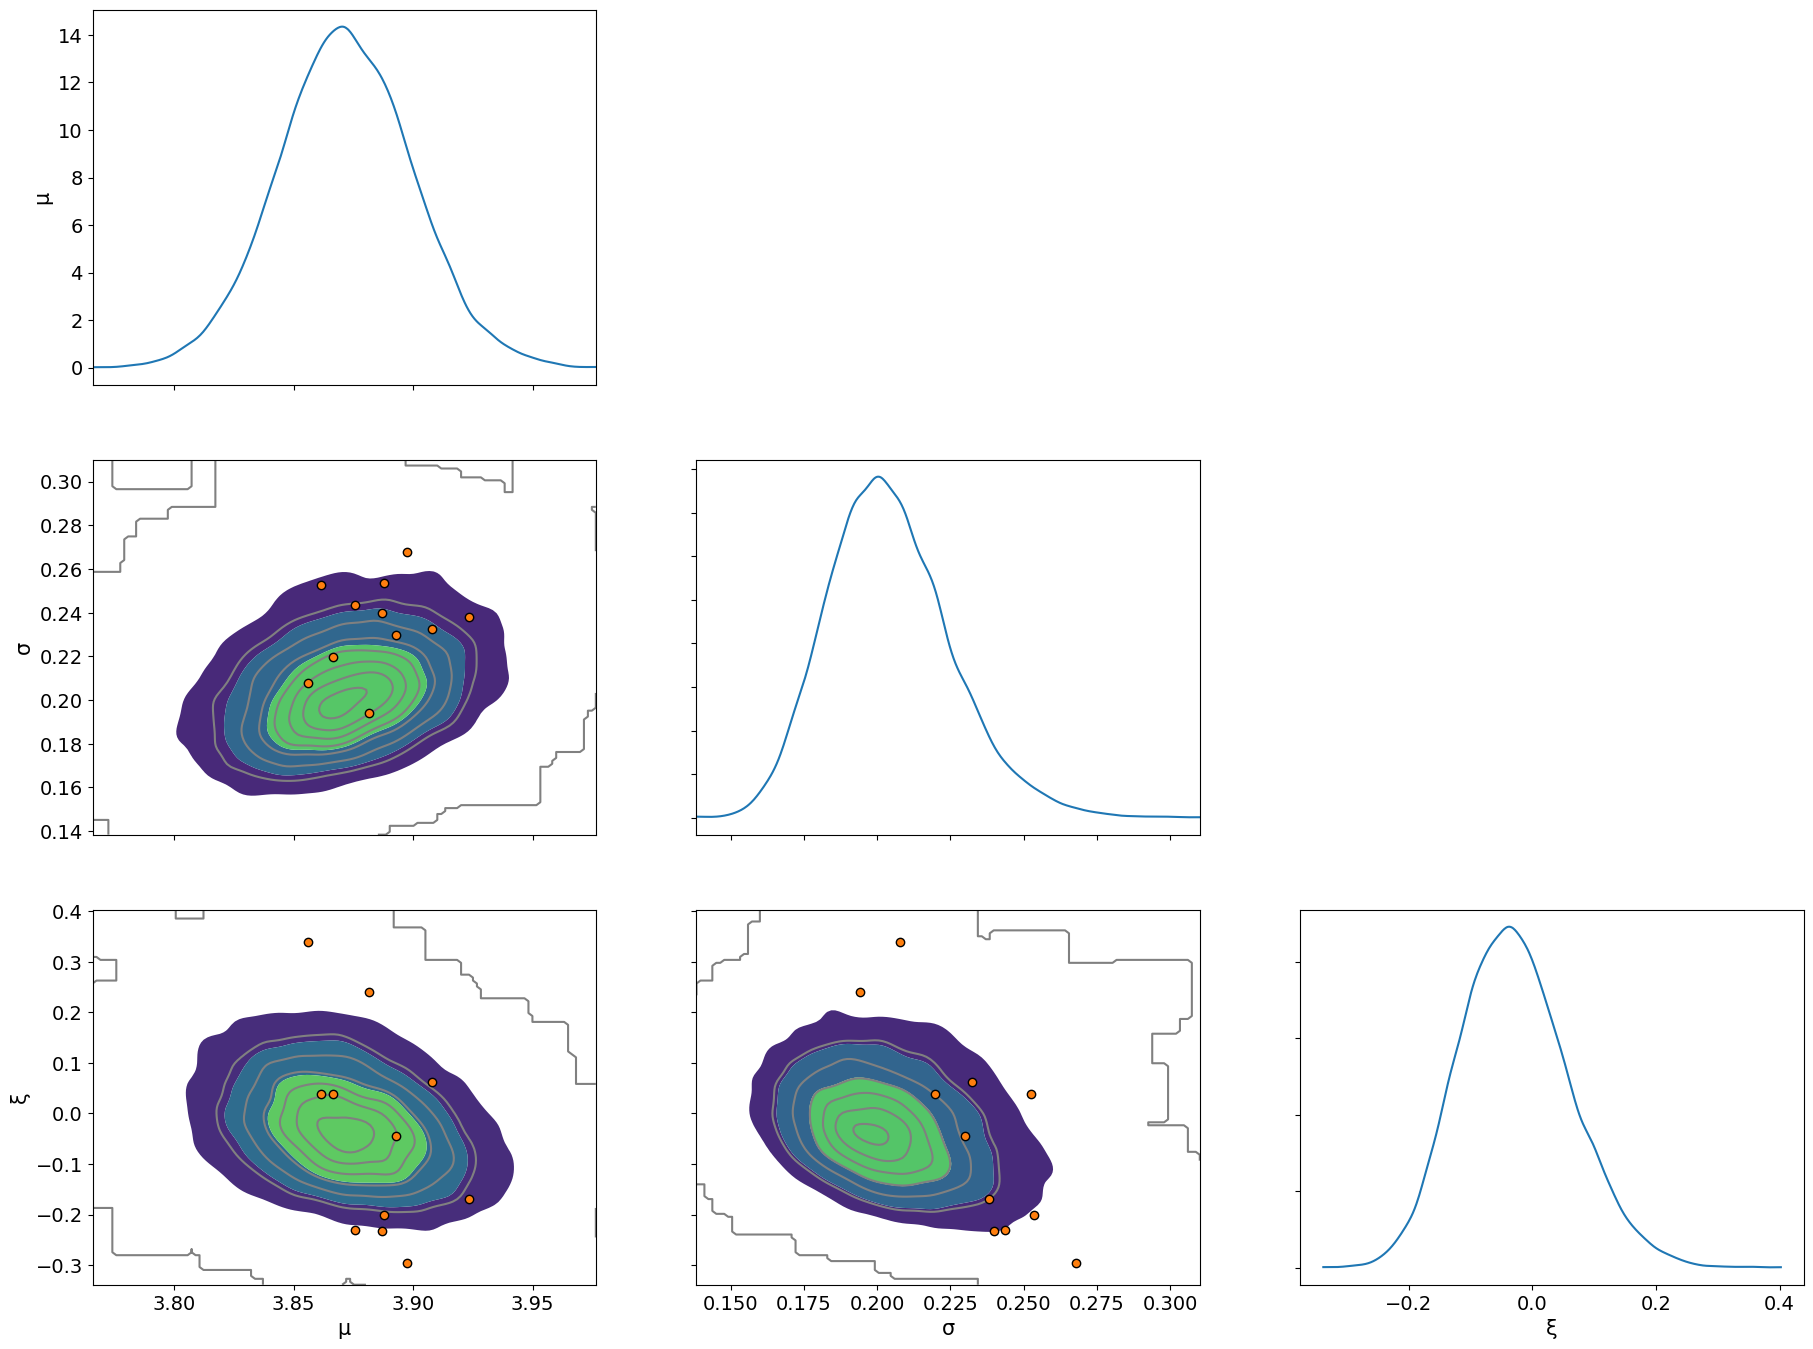

In [476]:
az.plot_pair(idata, var_names=["μ", "σ", "ξ"], kind="kde", marginals=True, divergences=True);

In [451]:
df_samples = idata["posterior"].to_dataframe().reset_index()
df_samples = df_samples[df_samples.chain==0] #Selected samples from one of the chains
df_samples.head(5)

,chain,draw,μ,σ,ξ
0,0,0,3.875573,0.212491,-0.141275
1,0,1,3.831314,0.201822,-0.005968
2,0,2,3.840739,0.210564,-0.079365
3,0,3,3.856372,0.203908,-0.042745
4,0,4,3.878133,0.190025,-0.117352


In [ ]:
return_levels_samples = np.zeros((np.shape(df_samples)[0],np.size(return_periods)))

for idx in range(0,np.shape(df_samples)[0]):
    mu_sample = df_samples["μ"][idx]
    sigma_sample= df_samples["σ"][idx]
    xi_sample = df_samples["ξ"][idx]
    params = np.array([-xi_sample,mu_sample,sigma_sample])
    sample_gev = genextreme(*params)
    return_levels_samples[idx,:] = sample_gev.ppf(1-1/return_periods)


return level z_p posterior

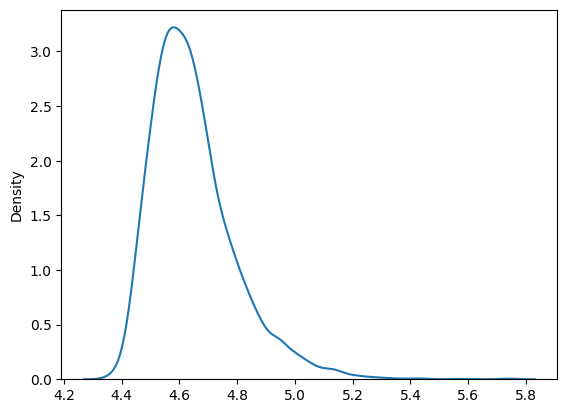

In [454]:
sns.kdeplot(return_levels_samples[:,50], label="Seaborn KDE");

In [457]:
rl_bay_q = np.quantile(return_levels_samples, [0.025, 0.5, 0.975], axis=0)

In [ ]:
##p = 1-1/return_periods

In [458]:
#p = 1/return_periods
#x = return_periods
#y_values = return_levels
points = np.array([np.column_stack([return_periods, y]) for y in return_levels_samples])

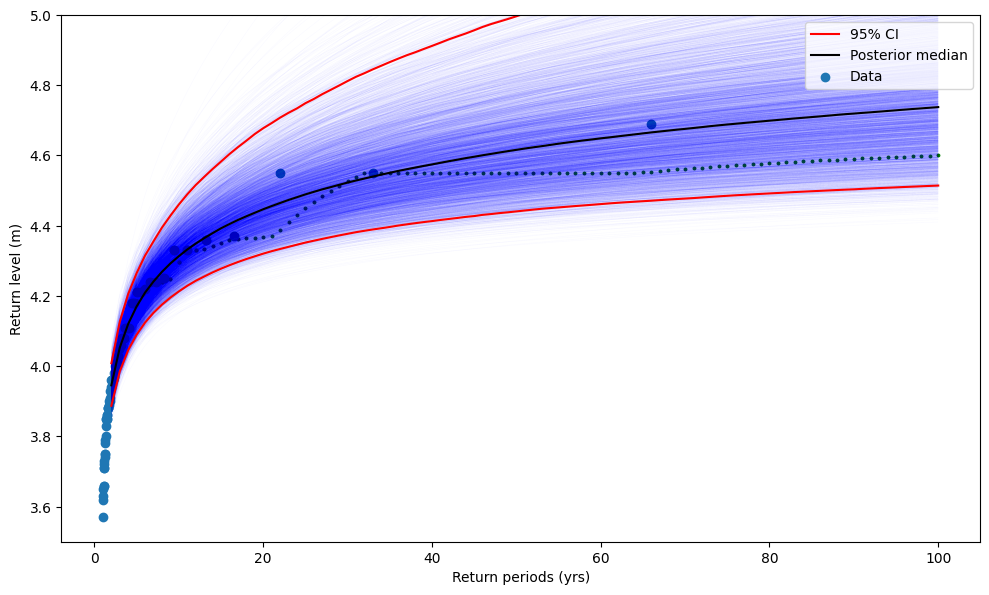

In [461]:
fig, ax = plt.subplots(figsize=(10, 6))
line_segments = LineCollection(points, 
alpha=0.02,  # Low alpha for better visualization
linewidth=0.5,
color='blue')
ax.add_collection(line_segments)
ax.plot(return_periods,rl_bay_q[0],color='red',label='95% CI')
ax.plot(return_periods,rl_bay_q[1],color='black',label='Posterior median')
ax.plot(return_periods,rl_bay_q[2],color='red')
ax.scatter(return_periods,return_levels_obs,s=3,color="green")
ax.scatter(Weibull_return_periods, sorted_data, marker='o', label='Data')
ax.autoscale()
ax.set_xlabel('Return periods (yrs)')
ax.set_ylabel('Return level (m)')
#ax.set_xticks(np.array([0,1,2]), labels=[1,10,100])
plt.tight_layout()
plt.ylim(3.5,5)
plt.legend();

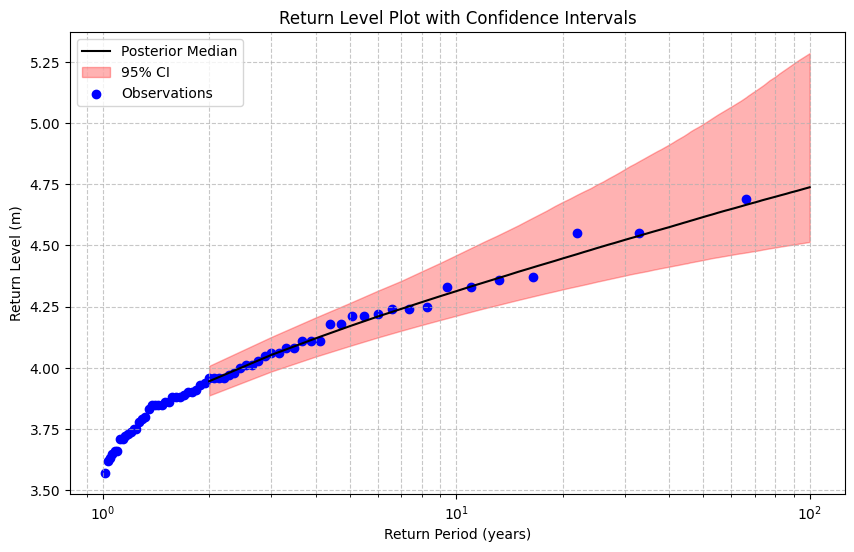

In [465]:
# Now plot
plt.figure(figsize=(10, 6))
plt.plot(return_periods,rl_bay_q[1], 'k-', label='Posterior Median')
plt.fill_between(return_periods, rl_bay_q[0], rl_bay_q[2], alpha=0.3, color='red', label='95% CI')

# Plot observations with their empirical return periods
plt.scatter(Weibull_return_periods, sorted_data, color='blue', marker='o', label='Observations')
plt.xscale('log')  # Log scale is standard for return period plots
plt.xlabel('Return Period (years)')
plt.ylabel('Return Level (m)')
plt.grid(True, which='both', linestyle='--', alpha=0.7)
plt.legend()
plt.title('Return Level Plot with Confidence Intervals')
plt.show()

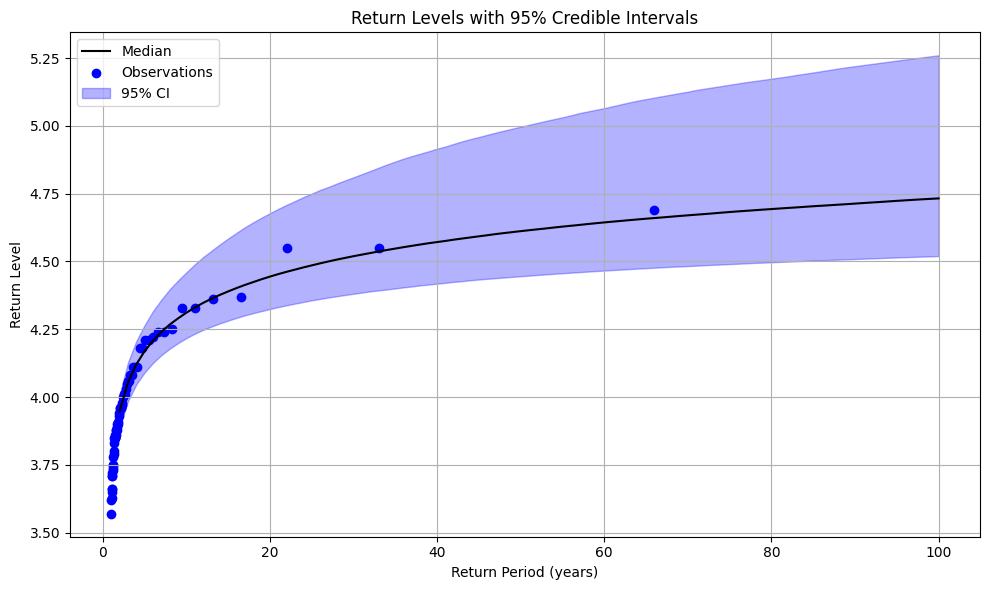

In [ ]:
# Create a plot of return levels with credible intervals
plt.figure(figsize=(10, 6))
plt.plot(return_periods, rl_bay_q[1], 'k-', label='Median')
plt.scatter(Weibull_return_periods, sorted_data, color='blue', marker='o', label='Observations')
plt.fill_between(return_periods, rl_bay_q[0], rl_bay_q[2], alpha=0.3, color='blue', label='95% CI')
plt.xlabel('Return Period (years)')
plt.ylabel('Return Level')
plt.title('Return Levels with 95% Credible Intervals')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Sampling: [gev]


Output()

/Users/luanbrito/Projects/bayesian_adventures/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


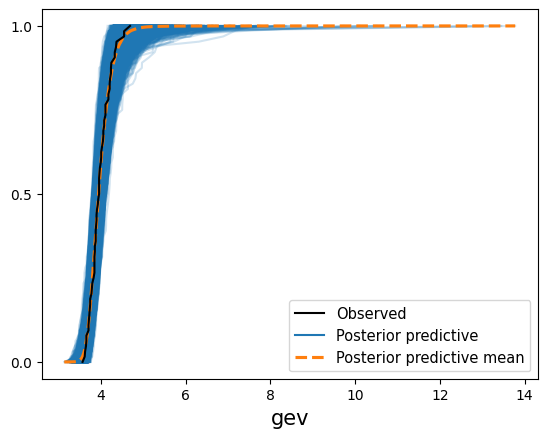

In [467]:
# Generate samples from the posterior predictive distribution
with model:
    post_pred = pm.sample_posterior_predictive(trace)

# Add to InferenceData object
idata.extend(post_pred)

# Plot posterior predictive check
az.plot_ppc(idata, kind='cumulative')#,legend=False)
plt.show()

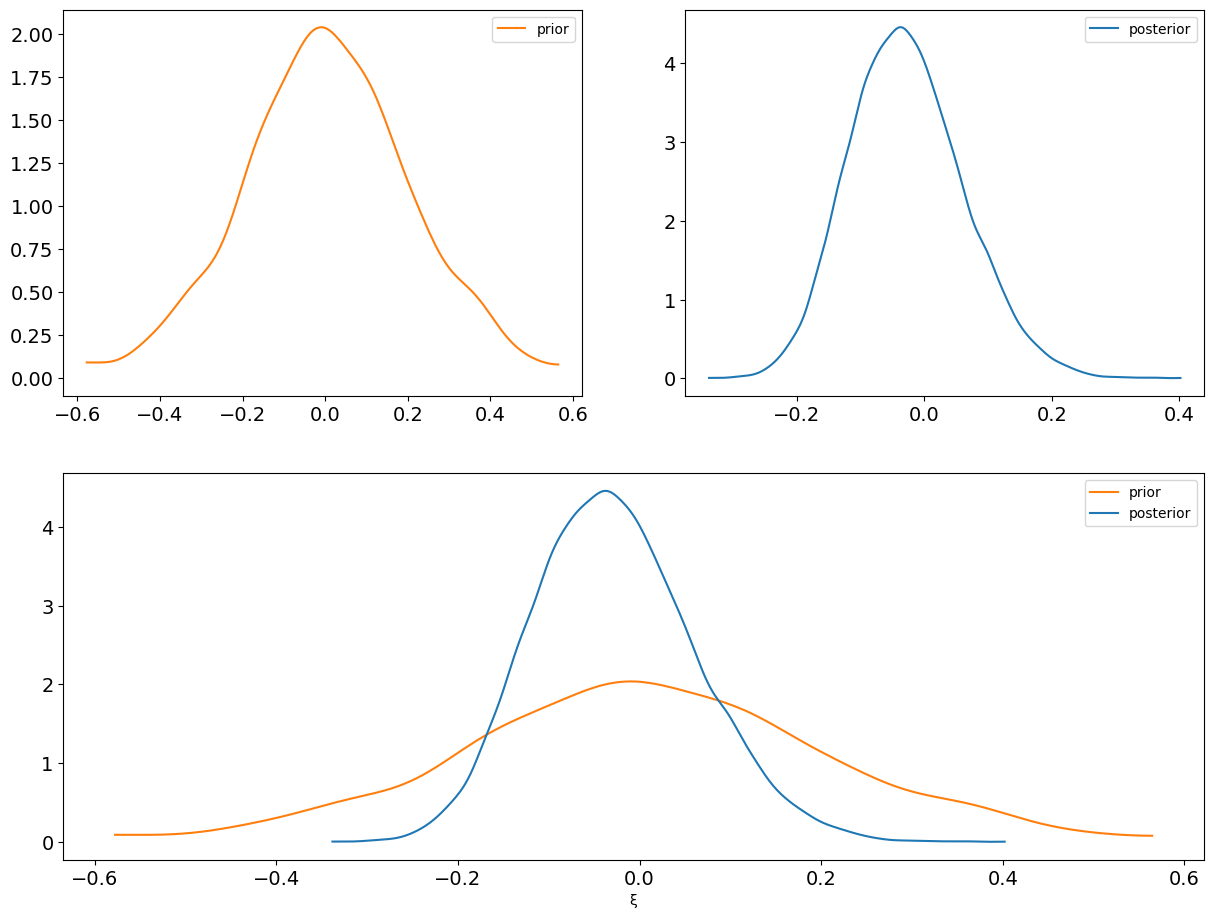

In [468]:
az.plot_dist_comparison(idata, var_names=["ξ"]);

Comparing the two models

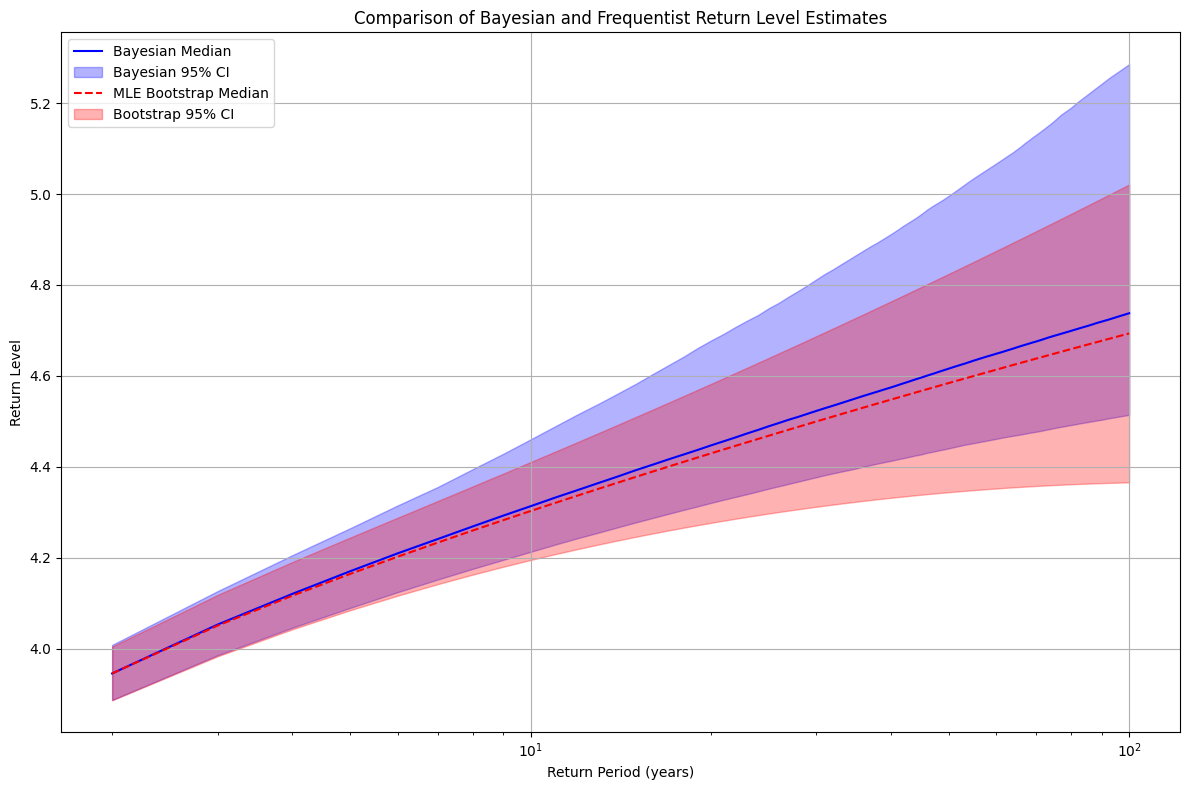

In [479]:
# Code to compare the two approaches

# For Bayesian results (from your previous code)
bayes_median = rl_bay_q[1]
bayes_lower = rl_bay_q[0]
bayes_upper = rl_bay_q[2]

# Assuming you have bootstrap results in similar format
# bootstrap_median, bootstrap_lower, bootstrap_upper

# Create comparison plot
plt.figure(figsize=(12, 8))
plt.plot(return_periods, bayes_median, 'b-', label='Bayesian Median')
plt.fill_between(return_periods, bayes_lower, bayes_upper, alpha=0.3, color='blue', label='Bayesian 95% CI')

plt.plot(return_periods, 2*mle_return_levels-boot_mean, 'r--', label='MLE Bootstrap Median')
plt.fill_between(return_periods, 2 * mle_return_levels-upper, 2*mle_return_levels - lower, alpha=0.3, color='red', label='Bootstrap 95% CI')

plt.xscale('log')  # Often useful for return period plots
plt.xlabel('Return Period (years)')
plt.ylabel('Return Level')
plt.title('Comparison of Bayesian and Frequentist Return Level Estimates')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

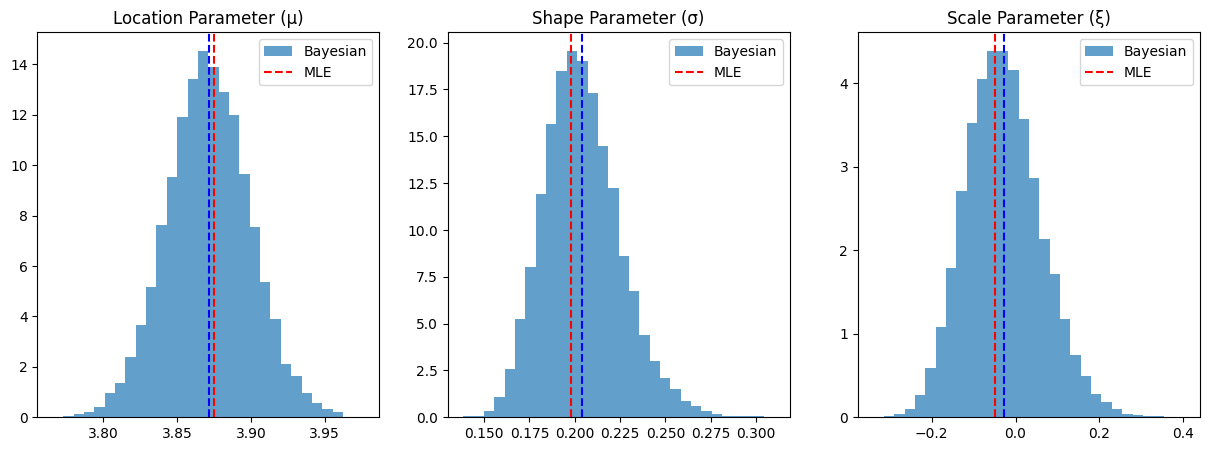

In [496]:
# Extract Bayesian parameter estimates
bayes_mu = idata.posterior["μ"].values.flatten()
bayes_sigma = idata.posterior["σ"].values.flatten()
bayes_xi = idata.posterior["ξ"].values.flatten()

# Create parameter comparison plots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot μ comparison
axes[0].hist(bayes_mu, bins=30, alpha=0.7, density=True, label='Bayesian')
axes[0].axvline(np.mean(bayes_mu), color='b', linestyle='--')
axes[0].axvline(mu, color='r', linestyle='--',label='MLE')
axes[0].set_title('Location Parameter (μ)')
axes[0].legend()

# Plot σ comparison
axes[1].hist(bayes_sigma, bins=30, alpha=0.7, density=True, label='Bayesian')
axes[1].axvline(np.mean(bayes_sigma), color='b', linestyle='--')
axes[1].axvline(sigma, color='r', linestyle='--',label='MLE')
axes[1].set_title('Shape Parameter (σ)')
axes[1].legend()

# Plot ξ comparison
axes[2].hist(bayes_xi, bins=30, alpha=0.7, density=True, label='Bayesian')
axes[2].axvline(np.mean(bayes_xi), color='b', linestyle='--')
axes[2].axvline(xi, color='r', linestyle='--',label='MLE')
axes[2].set_title('Scale Parameter (ξ)')
axes[2].legend()